In [12]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
def affine_matrix_from_points(v0, v1, shear=True, scale=True, usesvd=True):
    """Return affine transform matrix to register two point sets.

    v0 and v1 are shape (ndims, \*) arrays of at least ndims non-homogeneous
    coordinates, where ndims is the dimensionality of the coordinate space.

    If shear is False, a similarity transformation matrix is returned.
    If also scale is False, a rigid/Euclidean transformation matrix
    is returned.

    By default the algorithm by Hartley and Zissermann [15] is used.
    If usesvd is True, similarity and Euclidean transformation matrices
    are calculated by minimizing the weighted sum of squared deviations
    (RMSD) according to the algorithm by Kabsch [8].
    Otherwise, and if ndims is 3, the quaternion based algorithm by Horn [9]
    is used, which is slower when using this Python implementation.

    The returned matrix performs rotation, translation and uniform scaling
    (if specified).

    >>> v0 = [[0, 1031, 1031, 0], [0, 0, 1600, 1600]]
    >>> v1 = [[675, 826, 826, 677], [55, 52, 281, 277]]
    >>> affine_matrix_from_points(v0, v1)
    array([[   0.14549,    0.00062,  675.50008],
           [   0.00048,    0.14094,   53.24971],
           [   0.     ,    0.     ,    1.     ]])
    >>> T = translation_matrix(numpy.random.random(3)-0.5)
    >>> R = random_rotation_matrix(numpy.random.random(3))
    >>> S = scale_matrix(random.random())
    >>> M = concatenate_matrices(T, R, S)
    >>> v0 = (numpy.random.rand(4, 100) - 0.5) * 20
    >>> v0[3] = 1
    >>> v1 = numpy.dot(M, v0)
    >>> v0[:3] += numpy.random.normal(0, 1e-8, 300).reshape(3, -1)
    >>> M = affine_matrix_from_points(v0[:3], v1[:3])
    >>> numpy.allclose(v1, numpy.dot(M, v0))
    True

    More examples in superimposition_matrix()

    """
    numpy = np
    v0 = numpy.array(v0, dtype=numpy.float64, copy=True)
    v1 = numpy.array(v1, dtype=numpy.float64, copy=True)

    ndims = v0.shape[0]
    if ndims < 2 or v0.shape[1] < ndims or v0.shape != v1.shape:
        raise ValueError('input arrays are of wrong shape or type')

    # move centroids to origin
    t0 = -numpy.mean(v0, axis=1)
    M0 = numpy.identity(ndims+1)
    M0[:ndims, ndims] = t0
    v0 += t0.reshape(ndims, 1)
    t1 = -numpy.mean(v1, axis=1)
    M1 = numpy.identity(ndims+1)
    M1[:ndims, ndims] = t1
    v1 += t1.reshape(ndims, 1)

    if shear:
        # Affine transformation
        A = numpy.concatenate((v0, v1), axis=0)
        u, s, vh = numpy.linalg.svd(A.T)
        vh = vh[:ndims].T
        B = vh[:ndims]
        C = vh[ndims:2*ndims]
        t = numpy.dot(C, numpy.linalg.pinv(B))
        t = numpy.concatenate((t, numpy.zeros((ndims, 1))), axis=1)
        M = numpy.vstack((t, ((0.0,)*ndims) + (1.0,)))
    elif usesvd or ndims != 3:
        # Rigid transformation via SVD of covariance matrix
        u, s, vh = numpy.linalg.svd(numpy.dot(v1, v0.T))
        # rotation matrix from SVD orthonormal bases
        R = numpy.dot(u, vh)
        if numpy.linalg.det(R) < 0.0:
            # R does not constitute right handed system
            R -= numpy.outer(u[:, ndims-1], vh[ndims-1, :]*2.0)
            s[-1] *= -1.0
        # homogeneous transformation matrix
        M = numpy.identity(ndims+1)
        M[:ndims, :ndims] = R
    else:
        # Rigid transformation matrix via quaternion
        # compute symmetric matrix N
        xx, yy, zz = numpy.sum(v0 * v1, axis=1)
        xy, yz, zx = numpy.sum(v0 * numpy.roll(v1, -1, axis=0), axis=1)
        xz, yx, zy = numpy.sum(v0 * numpy.roll(v1, -2, axis=0), axis=1)
        N = [[xx+yy+zz, 0.0,      0.0,      0.0],
             [yz-zy,    xx-yy-zz, 0.0,      0.0],
             [zx-xz,    xy+yx,    yy-xx-zz, 0.0],
             [xy-yx,    zx+xz,    yz+zy,    zz-xx-yy]]
        # quaternion: eigenvector corresponding to most positive eigenvalue
        w, V = numpy.linalg.eigh(N)
        q = V[:, numpy.argmax(w)]
        q /= vector_norm(q)  # unit quaternion
        # homogeneous transformation matrix
        M = quaternion_matrix(q)

    if scale and not shear:
        # Affine transformation; scale is ratio of RMS deviations from centroid
        v0 *= v0
        v1 *= v1
        M[:ndims, :ndims] *= math.sqrt(numpy.sum(v1) / numpy.sum(v0))

    # move centroids back
    M = numpy.dot(numpy.linalg.inv(M1), numpy.dot(M, M0))
    M /= M[ndims, ndims]
    return M

In [14]:
def superimposition_matrix(v0, v1, scale=False, usesvd=True):
    """Return matrix to transform given 3D point set into second point set.

    v0 and v1 are shape (3, \*) or (4, \*) arrays of at least 3 points.

    The parameters scale and usesvd are explained in the more general
    affine_matrix_from_points function.

    The returned matrix is a similarity or Euclidean transformation matrix.
    This function has a fast C implementation in transformations.c.

    >>> v0 = numpy.random.rand(3, 10)
    >>> M = superimposition_matrix(v0, v0)
    >>> numpy.allclose(M, numpy.identity(4))
    True
    >>> R = random_rotation_matrix(numpy.random.random(3))
    >>> v0 = [[1,0,0], [0,1,0], [0,0,1], [1,1,1]]
    >>> v1 = numpy.dot(R, v0)
    >>> M = superimposition_matrix(v0, v1)
    >>> numpy.allclose(v1, numpy.dot(M, v0))
    True
    >>> v0 = (numpy.random.rand(4, 100) - 0.5) * 20
    >>> v0[3] = 1
    >>> v1 = numpy.dot(R, v0)
    >>> M = superimposition_matrix(v0, v1)
    >>> numpy.allclose(v1, numpy.dot(M, v0))
    True
    >>> S = scale_matrix(random.random())
    >>> T = translation_matrix(numpy.random.random(3)-0.5)
    >>> M = concatenate_matrices(T, R, S)
    >>> v1 = numpy.dot(M, v0)
    >>> v0[:3] += numpy.random.normal(0, 1e-9, 300).reshape(3, -1)
    >>> M = superimposition_matrix(v0, v1, scale=True)
    >>> numpy.allclose(v1, numpy.dot(M, v0))
    True
    >>> M = superimposition_matrix(v0, v1, scale=True, usesvd=False)
    >>> numpy.allclose(v1, numpy.dot(M, v0))
    True
    >>> v = numpy.empty((4, 100, 3))
    >>> v[:, :, 0] = v0
    >>> M = superimposition_matrix(v0, v1, scale=True, usesvd=False)
    >>> numpy.allclose(v1, numpy.dot(M, v[:, :, 0]))
    True

    """
    numpy = np
    v0 = numpy.array(v0, dtype=numpy.float64, copy=False)[:3]
    v1 = numpy.array(v1, dtype=numpy.float64, copy=False)[:3]
    return affine_matrix_from_points(v0, v1, shear=False,
                                     scale=scale, usesvd=usesvd)

In [15]:
def fibonacci_sphere(samples=1,randomize=True):
    """
    Creates N points on the surphase of a unity sphere."""
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points

In [16]:
def plot_sphere(coordinates, *args):
    """
    Plots a sphere and adds an arbitraty amount of other objects to the plot.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for dimension in range(0,3):
        dim_max = coordinates[:,dimension].max()*1.1
        dim_min = coordinates[:,dimension].min()*1.1
        if dimension == 0:
            ax.set_xlim3d(dim_min, dim_max)
        elif dimension == 1:
            ax.set_ylim3d(dim_min, dim_max)
        else:
            ax.set_zlim3d(dim_min, dim_max)
    ax.set_aspect('equal')
    ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2], zdir='z', s=20, c=None, depthshade=True)
    for arg in args:
        ax.scatter(arg[:,0], arg[:,1], arg[:,2])           
    plt.show()

In [17]:
def norm_vector(vector):
    new_vector_norm = vector/(vector**2).sum()**0.5
    return new_vector_norm

In [18]:
def rot_trans_fitting(vector1, vector2, object_3d, plotting = False):
    """
    Rotates and translates an object along a specified vector. The second vector is used
    to define rotation and should not be colinear with the first one. Plotting turns on the 
    troubleshooting plotting, displaying all original axes and the new ones, plus the original
    and transformed object. 
    
    Returns the transformed object as an array
    """
    #Defining 'normal' coordinate system
    vectorx = np.array([1,0,0])
    vectory = np.array([0,1,0])
    vectorz = np.array([0,0,1])
    basic_axes = np.array([vectorx, vectory, vectorz])
    
    #Calculating the new axes
    vector3 = np.cross(vector1, vector2)
    vector4 = np.cross(vector1, vector3)
    norm_vector1 = norm_vector(vector1)
    norm_vector2 = norm_vector(vector3)
    norm_vector3 = norm_vector(vector4)
    new_axes = np.array([norm_vector1, norm_vector2, norm_vector3])
    
    #Obtaining rotation matrix using library
    rotation_matrix = superimposition_matrix(basic_axes, new_axes)
    
    #Rotating all points to new axes
    cube_rot = []
    for point in object_3d:
        cube_rot.append(np.dot(point, rotation_matrix[:3, :3])+vector1)
    cube_rot = np.array(cube_rot)
    
    #Optional plotting
    if plotting:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim3d(-1.1, 1.1)
        ax.set_ylim3d(-1.1, 1.1)
        ax.set_zlim3d(-1.1, 1.1)
        ax.scatter(cube[:,0], cube[:,1], cube[:,2])
        ax.scatter(cube_rot[:,0], cube_rot[:,1], cube_rot[:,2])
        ax.quiver(0, 0, 0, vector1[0], vector1[1], vector1[2], color='red', lw=4)
        ax.quiver(0, 0, 0, norm_vector1[0], norm_vector1[1], norm_vector1[2], color='pink')
        ax.quiver(0, 0, 0, norm_vector2[0], norm_vector2[1], norm_vector2[2], color='pink')
        ax.quiver(0, 0, 0, norm_vector3[0], norm_vector3[1], norm_vector3[2], color='pink')
        ax.quiver(0, 0, 0, vectorx[0], vectorx[1], vectorx[2], color='blue')
        ax.quiver(0, 0, 0, vectory[0], vectory[1], vectory[2], color='blue')
        ax.quiver(0, 0, 0, vectorz[0], vectorz[1], vectorz[2], color='blue')
        plt.show()
    
    return cube_rot

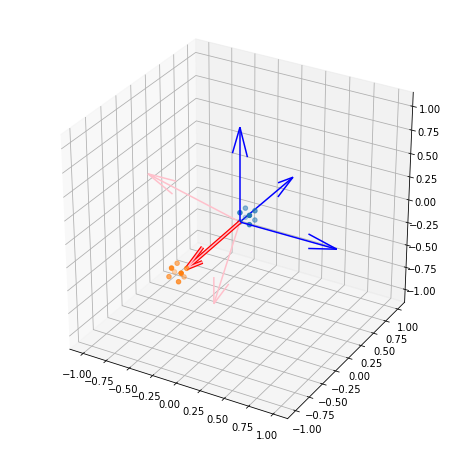

In [22]:
#Do the transformation for one cube on the surphase of a sphere.
sphere_coordinates = np.array(fibonacci_sphere(1000))
cube = (np.array([[0,0,1,1,0,0,1,1], [0,1,0,1,0,1,0,1], [0,0,0,0,1,1,1,1]]).T)*0.1
cube_rot = rot_trans_fitting(sphere_coordinates[0], sphere_coordinates[50], cube, True)

In [23]:
#Now project a cube on all points of the sphere
all_cube_rot = []
for idx in range(len(sphere_coordinates)):
    all_cube_rot.append(rot_trans_fitting(sphere_coordinates[idx], 
                                          sphere_coordinates[(idx+1)%len(sphere_coordinates)], 
                                          cube))
all_cube_rot = np.array(all_cube_rot)

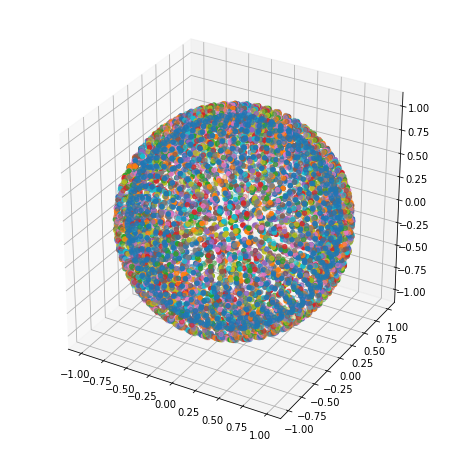

In [24]:
plot_sphere(sphere_coordinates, *all_cube_rot)